<a href="https://colab.research.google.com/github/minquan-alt/DeepLearning-Project/blob/main/traffic_signal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Signs Recognition

## 1. Packages

In [1]:
import gc
gc.collect()
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torchvision.models as models
from PIL import Image

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on NVIDIA GPU (CUDA)


## 2. Data pre-processsing

### 2.1. Load dataset

In [4]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)
os.listdir(path)

100%|██████████| 612M/612M [00:27<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


['Test',
 'Test.csv',
 'Meta',
 'Train',
 'train',
 'Meta.csv',
 'meta',
 'Train.csv',
 'test']

### 2.2. Load csv file

In [6]:
train_csv_path = os.path.join(path, 'Train.csv')
test_csv_path = os.path.join(path, 'Test.csv')
train_csv_df = pd.read_csv(train_csv_path)
test_csv_df = pd.read_csv(test_csv_path)

train_csv_df["Path"] = train_csv_df["Path"].apply(lambda x:os.path.join(path, x))
test_csv_df["Path"] = test_csv_df["Path"].apply(lambda x:os.path.join(path, x))

num_classes = len(train_csv_df["ClassId"].unique().tolist())


print(train_csv_df.head())
print(test_csv_df.head())
print(num_classes)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                                                Path  
0  /root/.cache/kagglehub/datasets/meowmeowmeowme...  
1  /root/.cache/kagglehub/datasets/meowmeowmeowme...  
2  /root/.cache/kagglehub/datasets/meowmeowmeowme...  
3  /root/.cache/kagglehub/datasets/meowmeowmeowme...  
4  /root/.cache/kagglehub/datasets/meowmeowmeowme...  
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     53      54       6       5      48      49       16   
1     42      45       5       5      36      40        1   
2     48      52       6       6      43      47       38   
3     27      29       5       5      22      24       33  

### 2.3. Preprocessing dataset

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        self.classes = sorted(self.data["ClassId"].unique().tolist())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["Path"]
        label = int(self.data.iloc[idx]["ClassId"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
train_dataset = CustomImageDataset(train_csv_df, transform=data_transforms)
test_dataset = CustomImageDataset(test_csv_df, transform=data_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=64
num_workers=2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 2.4. Review dataset

Train size:  39209
torch.Size([64, 3, 224, 224]) torch.Size([64])


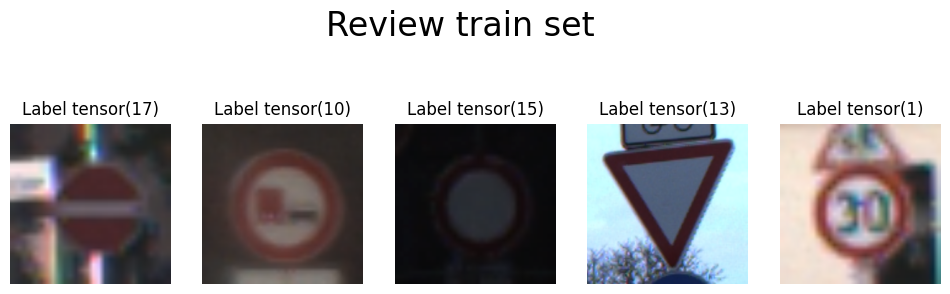

In [19]:
images, labels = next(iter(train_loader))
print("Train size: ", train_size + val_size)
print(images.shape, labels.shape)
mean = np.array([0.485, 0.456, 0.406])  # Mean của ImageNet
std = np.array([0.229, 0.224, 0.225])   # Std của ImageNet

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
fig.suptitle("Review train set", fontsize=24)
for i in range(5):
    img = images[i]
    img = img.permute((1, 2, 0)).numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label {str(labels[i])}")
    axes[i].axis("off")
plt.show()

## 3. Transfer learning

In [11]:
# load model
base_model = models.resnet18(pretrained=True)
base_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# edit output classes
base_model.fc = torch.nn.Linear(base_model.fc.in_features, num_classes)

In [13]:
# Optimization
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [14]:
def train_model(model, dataset, loss, optimizer, scheduler, num_epochs=10):
    model = model.to(device)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataset[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss_value = loss(outputs, labels)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataset[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataset[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if scheduler is not None:
            scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [20]:
dataset = {
    'train': train_loader,
    'val' : val_loader
}
for param in base_model.parameters():
    param.requires_grad = True
model = train_model(base_model, dataset, loss, optimizer, scheduler, num_epochs=10)

Epoch 1/10
train Loss: 0.0344 Acc: 0.9916
val Loss: 0.1167 Acc: 0.9707
Epoch 2/10
train Loss: 0.0242 Acc: 0.9942
val Loss: 0.0534 Acc: 0.9856
Epoch 3/10
train Loss: 0.0145 Acc: 0.9960
val Loss: 0.0608 Acc: 0.9834
Epoch 4/10
train Loss: 0.0068 Acc: 0.9984
val Loss: 0.0080 Acc: 0.9981
Epoch 5/10
train Loss: 0.0203 Acc: 0.9949
val Loss: 0.0473 Acc: 0.9888
Epoch 6/10
train Loss: 0.0022 Acc: 0.9995
val Loss: 0.0023 Acc: 0.9997
Epoch 7/10
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0019 Acc: 0.9997
Epoch 8/10
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0014 Acc: 0.9997
Epoch 9/10
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.0012 Acc: 0.9997
Epoch 10/10
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0011 Acc: 0.9997
Best val Acc: 0.9997


In [23]:
def evaluate(model, dataloader):
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  acc = correct / total
  print(f"Test Accuracy: {acc:.4f}")

In [24]:
evaluate(model, test_loader)

Test Accuracy: 0.9899


In [26]:
torch.save(model, "resnet18_traffic_sign_recognition_model.pth")

In [27]:
!ls -lh

total 43M
-rw-r--r-- 1 root root  43M Mar 24 09:05 resnet18_traffic_sign_recognition_model.pth
drwxr-xr-x 1 root root 4.0K Mar 20 13:31 sample_data
